In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization, Reshape, Dense, Input, LeakyReLU, Dropout, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam

import glob
from PIL import Image
import numpy as np
import os
import argparse
from ast import literal_eval

from imageio import imwrite

from matplotlib import pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
import tensorflow as tf
import cv2 as cv
import pandas as pd
import shutil

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-04-21 17:52:29.514263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 17:52:29.599841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 17:52:29.600681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## DCGAN Implementation

In [ ]:
class DCGAN:
    def __init__(self, discriminator_path, generator_path, output_directory, img_size):
        self.img_size = img_size
        self.upsample_layers = 5
        self.starting_filters = 64
        self.kernel_size = 4
        self.channels = 3
        self.discriminator_path = discriminator_path
        self.generator_path = generator_path
        self.output_directory = output_directory

    def build_generator(self):
        noise_shape = (100,)

        # This block of code can be a little daunting, but essentially it automatically calculates the required starting
        # array size that will be correctly upscaled to our desired image size.
        #
        # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
        # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
        # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
        # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
        model = Sequential()
        model.add(
            Dense(self.starting_filters * (self.img_size[0] // (2 ** self.upsample_layers))  *  (self.img_size[1] // (2 ** self.upsample_layers)),
                  activation="relu", input_shape=noise_shape))
        model.add(Reshape(((self.img_size[0] // (2 ** self.upsample_layers)),
                           (self.img_size[1] // (2 ** self.upsample_layers)),
                           self.starting_filters)))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 6x8 -> 12x16
        model.add(Conv2D(1024, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 12x16 -> 24x32
        model.add(Conv2D(512, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 24x32 -> 48x64
        model.add(Conv2D(256, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 48x64 -> 96x128
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 96x128 -> 192x256
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(32, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(self.channels, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_size[0], self.img_size[1], self.channels)

        model = Sequential()

        model.add(Conv2D(32, kernel_size=self.kernel_size, strides=2, input_shape=img_shape, padding="same"))  # 192x256 -> 96x128
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=self.kernel_size, strides=2, padding="same"))  # 96x128 -> 48x64
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(128, kernel_size=self.kernel_size, strides=2, padding="same"))  # 48x64 -> 24x32
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(256, kernel_size=self.kernel_size, strides=1, padding="same"))  # 24x32 -> 12x16
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, kernel_size=self.kernel_size, strides=1, padding="same"))  # 12x16 -> 6x8
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def build_gan(self):
        optimizer = Adam(0.0001, 0.5)

        # See if the specified model paths exist, if they don't then we start training new models

        if os.path.exists(self.discriminator_path) and os.path.exists(self.generator_path):
            self.discriminator = load_model(self.discriminator_path)
            self.generator = load_model(self.generator_path)
            print("Loaded models...")
        else:
            self.discriminator = self.build_discriminator()
            self.discriminator.compile(loss='binary_crossentropy',
                                       optimizer=optimizer,
                                       metrics=['accuracy'])

            self.generator = self.build_generator()
            self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # These next few lines setup the training for the GAN model
        z = Input(shape=(100,))
        img = self.generator(z)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def load_imgs(self, image_path):
        normalization = tf.keras.layers.Rescaling(1./255)
        dataset = image_dataset_from_directory(image_path, image_size=self.img_size)
        dataset = dataset.map(lambda x, y: (normalization(x), y))
        dataset = tfds.as_numpy(dataset)
        X_train = []
        for batch in dataset:
            X_train.append(batch[0])
        X_train = np.concatenate(X_train, axis=0)
        return np.asarray(X_train)

    def train(self, epochs, image_path, batch_size=32, save_interval=50):
        self.build_gan()
        X_train = self.load_imgs(image_path)
        print("Training Data Shape: ", X_train.shape)

        # Rescale images from -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = batch_size // 2

        for epoch in range(epochs):


            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))



            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Print progress
            print(f"{epoch} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

            # If at save interval => save generated image samples, save model files
            if epoch % (save_interval) == 0:

                self.save_imgs(epoch)

                save_path = self.output_directory + "/models"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                self.discriminator.save(save_path + "/discrim.h5")
                self.generator.save(save_path + "/generat.h5")
            
            # Save history anyway
            self.save_history(d_loss[0], d_loss[1], g_loss)
                
    def save_history(self, d_loss, d_acc, g_loss):
        save_path = self.output_directory + "/history.csv"
        history = pd.DataFrame({'Discriminator loss': [d_loss],
                               'Discriminator accuracy x100': [d_acc],
                               'Generator loss': [g_loss]})
        history.to_csv(save_path, mode='a', header=not os.path.exists(save_path))

    def gene_imgs(self, count):
        # Generate images from the currently loaded model
        noise = np.random.normal(0, 1, (count, 100))
        return self.generator.predict(noise)

    def save_imgs(self, epoch):
        r, c = 5, 5

        # Generates r*c images from the model, saves them individually and as a gallery

        imgs = self.gene_imgs(r*c)
        imgs = 0.5 * imgs + 0.5

        for i, img_array in enumerate(imgs):
            path = f"{self.output_directory}/generated_{self.img_size[0]}x{self.img_size[1]}"
            if not os.path.exists(path):
                os.makedirs(path)
            imwrite(path + f"/{epoch}_{i}.png", img_array)

        nindex, height, width, intensity = imgs.shape
        nrows = nindex // c
        assert nindex == nrows * c
        # want result.shape = (height*nrows, width*ncols, intensity)
        gallery = (imgs.reshape(nrows, c, height, width, intensity)
                  .swapaxes(1, 2)
                  .reshape(height * nrows, width * c, intensity))

        path = f"{self.output_directory}/gallery_generated_{self.img_size[0]}x{self.img_size[1]}"
        if not os.path.exists(path):
            os.makedirs(path)
        imwrite(path + f"/{epoch}.png", gallery)

    def generate_imgs(self, count, threshold, modifier):
        self.build_gan()

        # Generates (count) images from the model ensuring the discriminator scores them between the threshold values
        # and saves them

        imgs = []
        for i in range(count):
            score = [0]
            while not(threshold[0] < score[0] < threshold[1]):
                img = self.gene_imgs(1)
                score = self.discriminator.predict(img)
            print("Image found: ", score[0])
            imgs.append(img)

        imgs = np.asarray(imgs).squeeze()
        imgs = 0.5 * imgs + 0.5

        print(imgs.shape)
        for i, img_array in enumerate(imgs):
            path = f"{self.output_directory}/generated_{threshold[0]}_{threshold[1]}"
            if not os.path.exists(path):
                os.makedirs(path)
            imwrite(path + f"/{modifier}_{i}.png", img_array)

## Dataset

In [ ]:
path = '../input/abstract-art-gallery/Abstract_gallery'
os.path.exists(path)

True

In [ ]:
dataset = image_dataset_from_directory(path, batch_size=32)
dataset

Found 2782 files belonging to 1 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

2022-04-21 17:52:54.564933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


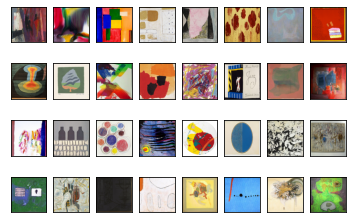

In [ ]:
example_batch = dataset.take(1)
for images, labels in example_batch:
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(images[i].numpy().astype("uint8"))

## Training

In [ ]:
load_discriminator = "data/models/discrim.h5"
load_generator = "data/models/generat.h5"
data = '../input/abstract-art-gallery/Abstract_gallery'
sample = -1
sample_thresholds = (0.0, 0.1)
batch_size = 24
image_size = (128,128)
epochs=5000
save_interval = 100
output_directory = "data/output/test"

In [ ]:
print(os.path.exists(load_discriminator))
print(os.path.exists(load_generator))

False
False


In [ ]:
dcgan = DCGAN(load_discriminator, load_generator, output_directory, image_size)

In [ ]:
dcgan.train(epochs=epochs, image_path=data, batch_size=batch_size, save_interval=save_interval)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 64, 64, 32)        1568      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 64)        32832     
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 33, 33, 64)       

In [ ]:
! ls

__notebook_source__.ipynb  data


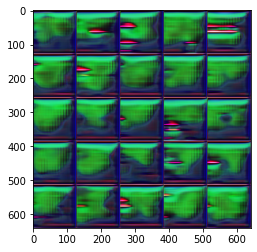

In [ ]:
img=cv.imread('data/output/test/gallery_generated_128x128/400.png')
plt.imshow(img)

In [ ]:
shutil.rmtree("data/output/test")

In [ ]:
pd.read_csv('./data/output/test/history.csv')

,Unnamed: 0,Discriminator loss,Discriminator accuracy x100,Generator loss
0,0,3.063275e+00,0.208333,0.669720
1,0,4.891743e-01,0.625000,0.566954
2,0,9.370939e-01,0.458333,0.935971
3,0,1.068563e+00,0.458333,0.755646
4,0,3.967178e-01,0.916667,0.954665
...,...,...,...,...
10510,0,1.650872e-08,1.000000,0.000338
10511,0,1.343069e-08,1.000000,0.000858
10512,0,2.833178e-08,1.000000,0.000771
10513,0,1.864062e-08,1.000000,0.000396


In [ ]:
sum(os.path.getsize(f) for f in os.listdir('data/output/test/generated_128x128') if os.path.isfile(f))

0

## My analysis of results

In [ ]:
path_history = './data/output/test/history.csv'
path_gallery = './data/output/test/gallery_generated_128x128/'

In [ ]:
df = pd.read_csv(path_history).tail(5000)
df

,Unnamed: 0,Discriminator loss,Discriminator accuracy x100,Generator loss
5515,0,1.778007e+00,0.083333,0.759310
5516,0,4.915312e-01,0.750000,0.652471
5517,0,4.139030e-01,0.958333,0.739892
5518,0,4.375757e-01,0.958333,0.790328
5519,0,4.352837e-01,0.875000,0.796778
...,...,...,...,...
10510,0,1.650872e-08,1.000000,0.000338
10511,0,1.343069e-08,1.000000,0.000858
10512,0,2.833178e-08,1.000000,0.000771
10513,0,1.864062e-08,1.000000,0.000396


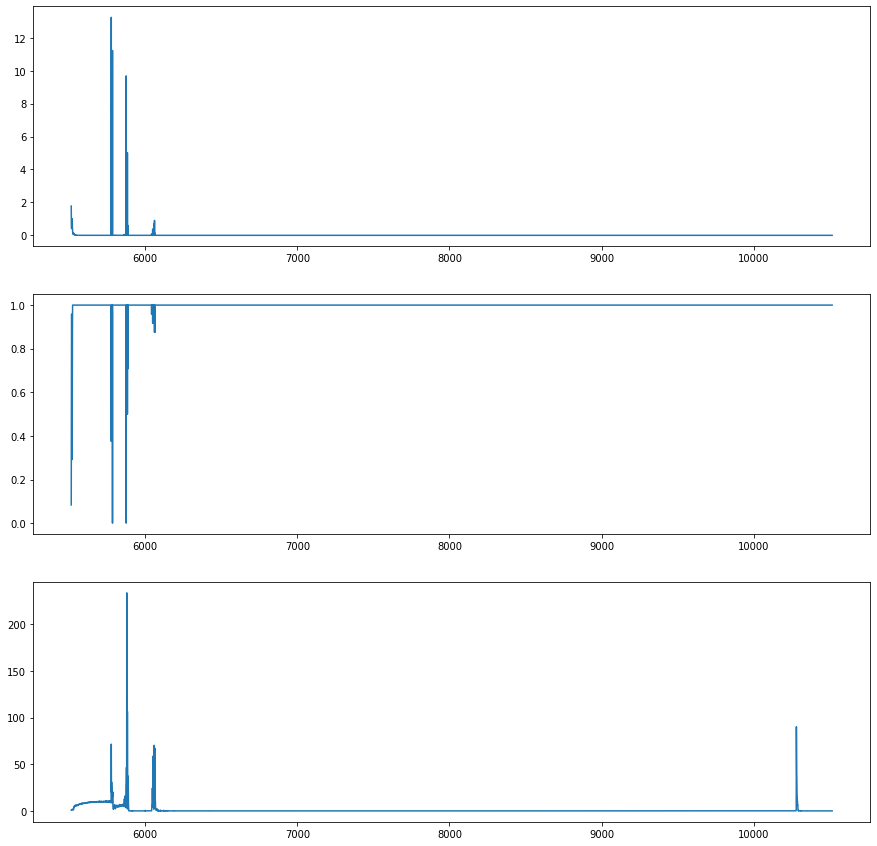

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,15))
ax1.plot(df["Discriminator loss"])
ax2.plot(df["Discriminator accuracy x100"])
ax3.plot(df["Generator loss"])

In [ ]:
img_names = os.listdir(path_gallery)

In [ ]:
from functools import cmp_to_key
def sorter(x1, x2):
    n1 = int(x1[:-4])
    n2 = int(x2[:-4])
    return n1 - n2

In [ ]:
img_names.sort(key=cmp_to_key(sorter))
len(img_names)

50

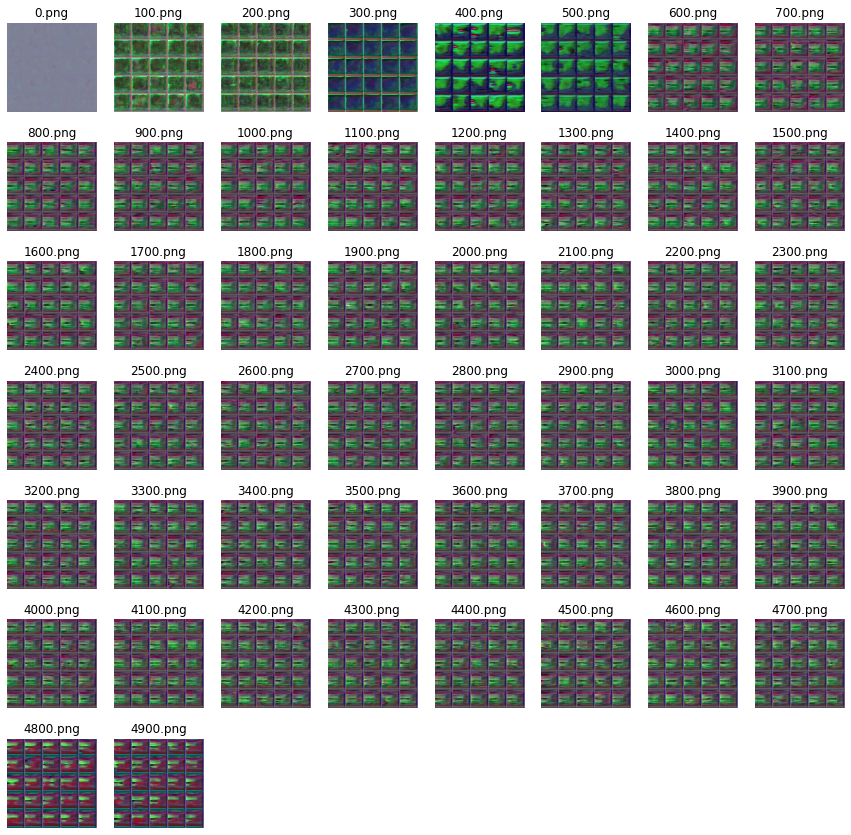

In [ ]:
plt.figure(figsize=(15,15))
for i in range(len(img_names)):
    ax = plt.subplot(7,8,i+1)
    img = cv.imread(path_gallery+img_names[i])
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    cv.resize(img, dim)
    plt.imshow(img)
    plt.axis("off")
    ax.set_title(img_names_shorter[i])

In [ ]:
def load_imgs(image_path, img_size):
    normalization = tf.keras.layers.Rescaling(1./255)
    dataset = image_dataset_from_directory(image_path, image_size=img_size)
    dataset = dataset.map(lambda x, y: (normalization(x), y))
    dataset = tfds.as_numpy(dataset)
    X_train = []
    for batch in dataset:
        X_train.append(batch[0])
    X_train = np.concatenate(X_train, axis=0)
    return np.asarray(X_train)

In [ ]:
image_size = (128,128)
X = load_imgs(data, image_size)

Found 2782 files belonging to 1 classes.
